# Gaussian mixtures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import xarray as xr

### Import the data

In [2]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1
    
stack_array = stack_data.to_array(dim="band")

df_raster = stack_data.to_dataframe()[vars_vec]

rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]

# from sklearn import preprocessing as prep
# df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona)) ## no need to standardize for gaussian mixtures?

## Estimate mixture models with different assumptions

**(how to initialize? Can have a big impact on the result, Fraley paper: initialize from discrete, hierarchical clustering method)**

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
cv_types = ['spherical', 'tied', 'diag', 'full']
cluster_range = range(2,11)


bic = []
for cvtype in cv_types:
    for ncluster in cluster_range:
        
        model = GaussianMixture(n_components = ncluster, covariance_type=cvtype)
        model.fit(df_nona)
        bic.append(model.bic(df_nona))



array([8, 7, 7, 8], dtype=int64)

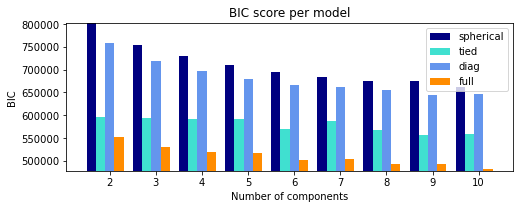

In [19]:
import itertools

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(cluster_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(cluster_range):
                                  (i + 1) * len(cluster_range)],
                        width=.2, color=color))
plt.xticks(cluster_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.set_ylabel('BIC')
spl.legend([b[0] for b in bars], cv_types)

Again the BIC keeps decreasing as more components are added, so there is no clear optimum in number of components to the mixture distribution.\
Clearly, leaving all parameters of each multivariate normal free results in the model with the smallest BIC.  This means that each 'cluster' has a different covariance structure between the variables. There is a local minimum of the BIC for the full covariance matrix at 6 clusters.

In [24]:
print(bic.reshape(4,9).argmin(axis=1))
bic.reshape(4,9)

[8 7 7 8]


array([[803119.54712729, 753490.72132801, 729225.49780674,
        710443.29109543, 695253.94403843, 683461.06043708,
        675967.3803903 , 675621.05226863, 661496.65995961],
       [595707.98286933, 593377.9120827 , 591669.1393106 ,
        590760.17837815, 569717.19779975, 588246.60064008,
        567362.27694671, 556094.39679609, 559100.12971465],
       [759201.80233496, 718751.86407456, 697298.43302668,
        680099.774898  , 667173.69740568, 662357.07734116,
        654221.1583125 , 643818.63915662, 645420.67840224],
       [552876.87161246, 529131.14932567, 519889.81747373,
        517567.20680487, 501441.7764691 , 504476.68759671,
        493158.79213579, 492974.99109295, 481189.11089537]])

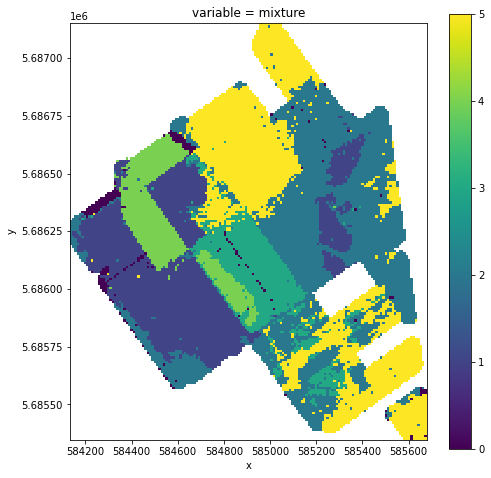

In [28]:
model = GaussianMixture(n_components = 6, covariance_type='full').fit(df_nona)
clusters = model.predict(df_nona) # each pixel assigned to cluster that has largest probability

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['mixture_full6'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='mixture_full6').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

Since this is a model based approach, also indicators for the uncertainty of the classification of a certain observation can be derived. For each observations, estimations of the probability of belonging to each cluster are calculated. The observation is then classified to the cluster for which the respective probability is largest. This probability should be as high as possible to have little uncertainty on the classification. To learn about the spatial distribution of the uncertainty of the classification, this maximal probability can be plotted by its respective coordinates.

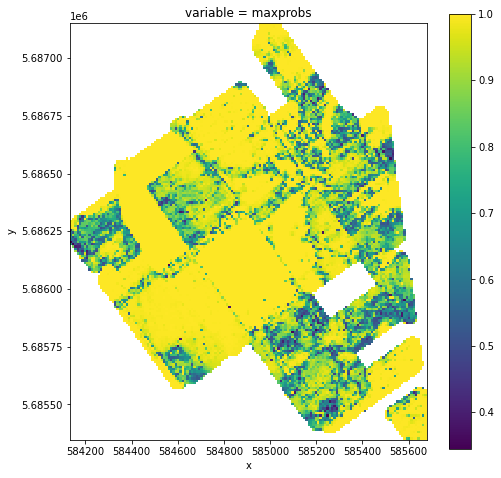

In [26]:
probs = model.predict_proba(df_nona)
maxprobs = probs.max(axis=1)

cl = np.empty((27540))
cl[:] = np.nan
cl[~rows_with_nan] = maxprobs
df_raster['maxprobs'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='maxprobs').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

Having the full covariance matrix fitted in the process is very flexible, but prone to overfitting. It could detect clusters that are due to drift of the instrument and therefore creates clusters that are not interesting for interpretation of the data. Comparing the map above with the surveys shows that an influence of drift might indeed be true.

<AxesSubplot:>

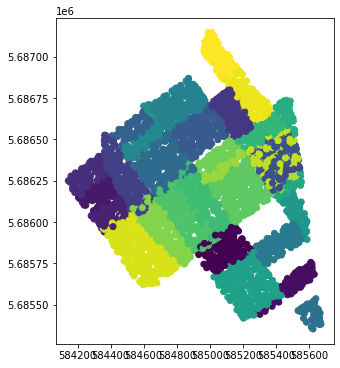

In [31]:
gdf5000 = geopandas.read_file('../Data/Data_geojson/gdf5000.geojson')
gdf5000.plot(column='survey', figsize=(6,6))

For this reason it may be a better option impose more restrictions on the mixture model. The model with a tied covariance matrix, i.e. elliptical clusters with the same covariance structure for each cluster, also performed well and its BIC had a local minimum for 6 clusters as well. 

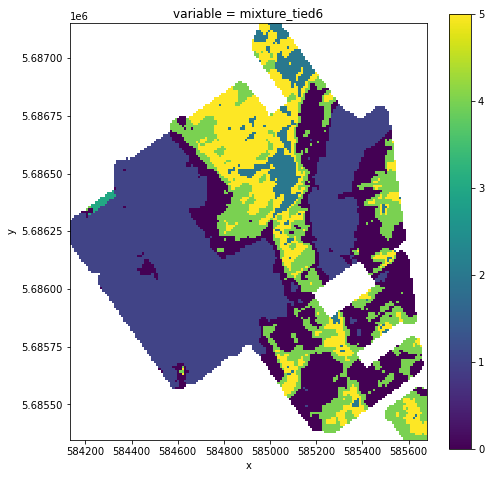

In [36]:
model = GaussianMixture(n_components = 6, covariance_type='tied').fit(df_nona)
clusters = model.predict(df_nona) # each pixel assigned to cluster that has largest probability

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['mixture_tied6'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='mixture_tied6').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

This classification makes more sense in how it reflects the global trends in the data. It clearly clusters according to the trend from high to low ECa, it would be interesting to see if some of its classes are also due to more subtle differences in EMI response.\
**Maybe compare with a map of the first PC to see if it is only reflecting this trend or more**

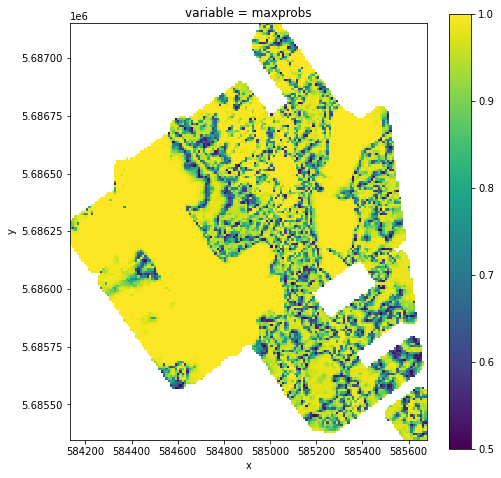

In [37]:
probs = model.predict_proba(df_nona)
maxprobs = probs.max(axis=1)

cl = np.empty((27540))
cl[:] = np.nan
cl[~rows_with_nan] = maxprobs
df_raster['maxprobs'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='maxprobs').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

This shows that a large area is homogeneous and can easily be clustered. The transition to the area with a higher conductivity is more difficult to cluster. This is evident if the transition is gradual without an clear indication of where to put the cluster boundaries.